In [0]:
import os, time, itertools, pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [0]:
tf.reset_default_graph()

In [0]:
def leaky_relu(x, th = 0.2):
    return tf.maximum(th*x, x)


def generator(x, y, istrain = True, reuse = tf.AUTO_REUSE):
    
    with tf.variable_scope('generator', reuse = reuse):
        w_init = tf.contrib.layers.xavier_initializer()
        g_input = tf.concat([x, y], 1)
        
        fc1 = tf.nn.relu(tf.layers.dense(g_input, 128, kernel_initializer = w_init))
        fc2 = tf.layers.dense(fc1, 784, kernel_initializer = w_init)
        generated_outputs = tf.nn.tanh(fc2)
        
        return generated_outputs
    
def discriminator(x, y, isTrain = True, reuse  = tf.AUTO_REUSE):
    with tf.variable_scope('discriminator', reuse = reuse):
        w_init = tf.contrib.layers.xavier_initializer()

        d_input = tf.concat([x, y], 1)

        fc1 =leaky_relu(tf.layers.dense(d_input, 128, kernel_initializer = w_init))
        fc2 = tf.layers.dense(fc1, 1, kernel_initializer = w_init)
        discriminator_outputs = tf.nn.sigmoid(fc2)

        return discriminator_outputs, fc2

In [0]:
x  = tf.placeholder(tf.float32, shape = (None, 784))
y  = tf.placeholder(tf.float32, shape = (None, 10))
z  = tf.placeholder(tf.float32, shape = (None, 100))
isTrain = tf.placeholder(dtype=tf.bool)

In [5]:
batch_size = 100
leraning_rate = 0.002
epochs = 100

mnist = input_data.read_data_sets("MNIST_data/", one_hot  = True)
train_set = (mnist.train.images  - 0.5) / 0.5
print(np.shape(train_set))
print(len(train_set))

train_labels = mnist.train.labels
print(len(train_labels))

W0824 04:24:27.743820 139680907270016 deprecation.py:323] From <ipython-input-5-41d44811ad09>:5: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0824 04:24:27.745646 139680907270016 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0824 04:24:27.746932 139680907270016 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz


W0824 04:24:28.663464 139680907270016 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0824 04:24:28.665839 139680907270016 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz


W0824 04:24:29.339913 139680907270016 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)
55000
55000


In [6]:
G_z = generator(z, y, isTrain)
D_real, D_real_logits = discriminator(x, y, isTrain)
D_fake, D_fake_logits = discriminator(G_z, y, isTrain, reuse = True)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_real_logits,  
                                                                     labels = tf.ones([batch_size, 1])))

D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_fake_logits,  
                                                                     labels = tf.zeros([batch_size, 1])))

G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_fake_logits,  
                                                                     labels = tf.ones([batch_size, 1])))

D_loss = D_loss_real + D_loss_fake


W0824 04:24:29.718154 139680907270016 deprecation.py:323] From <ipython-input-3-587169423ec8>:11: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0824 04:24:29.979047 139680907270016 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')


In [0]:
G_solver = tf.train.AdamOptimizer(learning_rate=1e-3,beta1=0.5).minimize(G_loss, var_list=G_vars)
D_solver = tf.train.AdamOptimizer(learning_rate=1e-3,beta1=0.5).minimize(D_loss, var_list=D_vars)


In [0]:
sess  = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [0]:
onehot = np.eye(10)

fixed_z_ = np.random.normal(0,1 ,(25,100))
fixed_y_ = np.random.randint(0, 9, (25, 1))
fixed_y_ = onehot[fixed_y_.astype(np.int32)].squeeze()

def show_result(num_epoch):
    test_images = sess.run(G_z, {z:fixed_z_, y: fixed_y_, isTrain: False})
    
    size_figure_grid = 5
    
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize = (5,5))
    
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        
        for k in range(size_figure_grid*size_figure_grid):
            i = k //size_figure_grid
            j = k % size_figure_grid
            ax[i, j].cla()
            ax[i,j].imshow(np.reshape(test_images[k], (28, 28)),cmap = 'gray')
            
        label = 'Epoch {0}'.format(num_epoch)
        fig.text(0.5, 0.04, label, ha = 'center')
        
        plt.show()

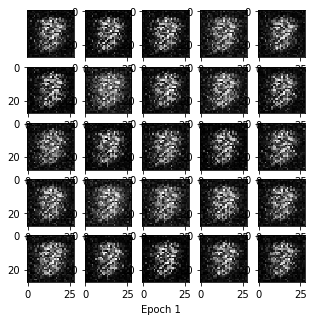

Iter : 0
D_loss : 1.427465796470642
G_loss : 0.4888577163219452



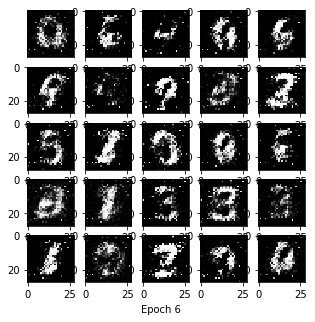

Iter : 5
D_loss : 1.0820249319076538
G_loss : 0.8870862722396851



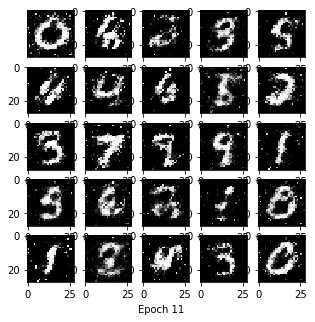

Iter : 10
D_loss : 1.2278525829315186
G_loss : 0.5771979689598083



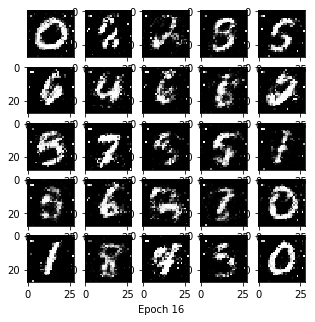

Iter : 15
D_loss : 1.2610273361206055
G_loss : 0.8452557325363159



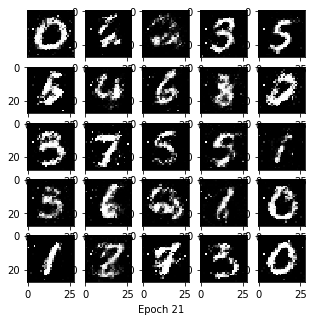

Iter : 20
D_loss : 1.1584393978118896
G_loss : 1.0386075973510742



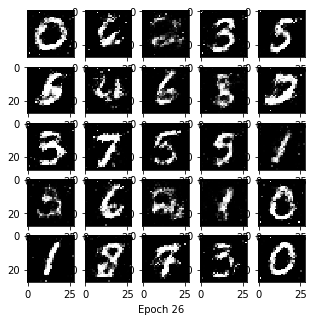

Iter : 25
D_loss : 1.2124699354171753
G_loss : 0.8470227718353271



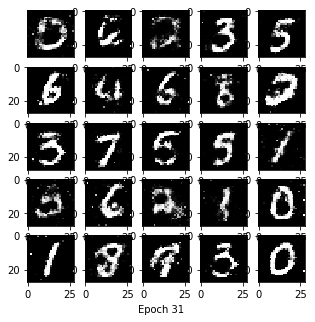

Iter : 30
D_loss : 1.2965905666351318
G_loss : 0.6909986138343811



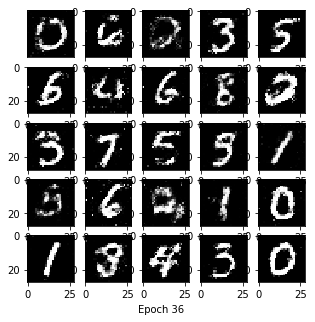

Iter : 35
D_loss : 1.2372658252716064
G_loss : 0.6980125308036804



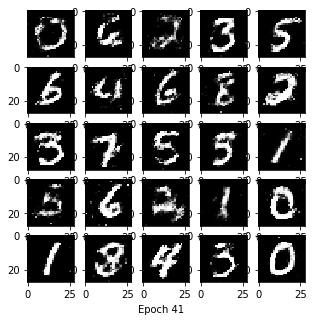

Iter : 40
D_loss : 1.2551243305206299
G_loss : 0.7659071087837219



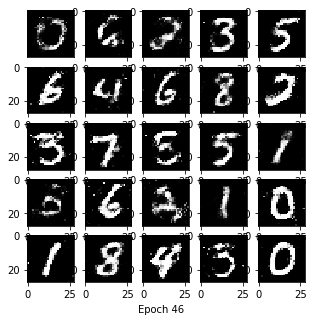

Iter : 45
D_loss : 1.2315679788589478
G_loss : 0.8589964509010315



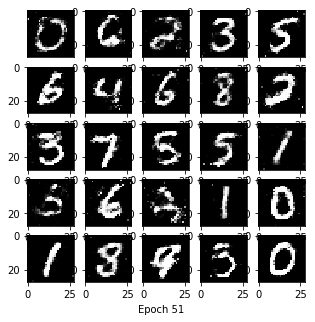

Iter : 50
D_loss : 1.1972408294677734
G_loss : 1.0473889112472534



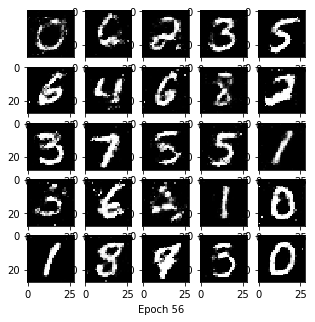

Iter : 55
D_loss : 1.2254589796066284
G_loss : 0.8633910417556763



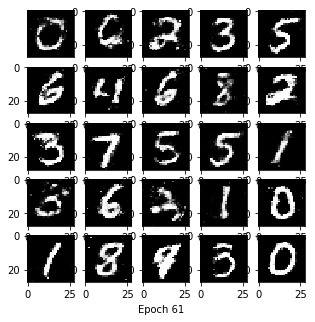

Iter : 60
D_loss : 1.1260031461715698
G_loss : 0.8450325131416321



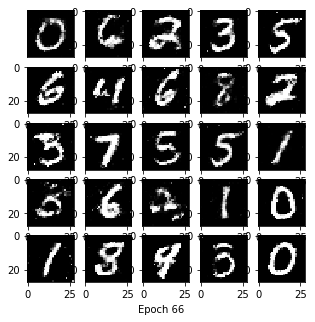

Iter : 65
D_loss : 1.2664810419082642
G_loss : 0.6390493512153625



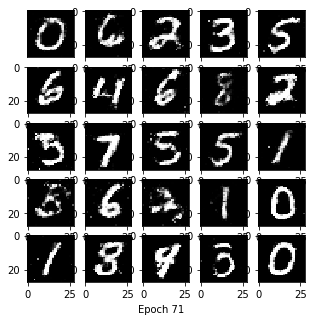

Iter : 70
D_loss : 1.0974072217941284
G_loss : 0.9154571294784546



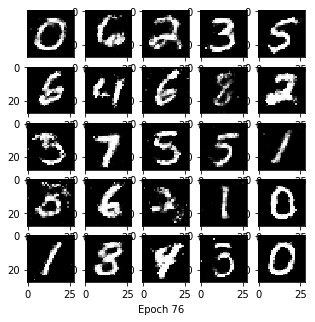

Iter : 75
D_loss : 1.1397440433502197
G_loss : 0.7756641507148743



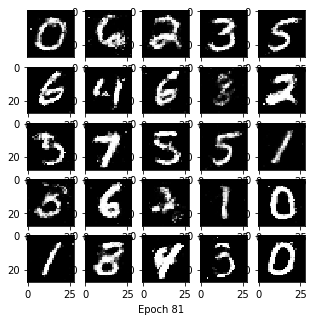

Iter : 80
D_loss : 1.1896238327026367
G_loss : 0.7273209095001221



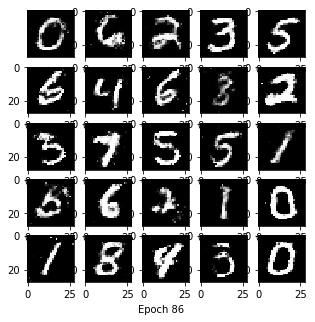

Iter : 85
D_loss : 1.2605863809585571
G_loss : 0.7097541093826294



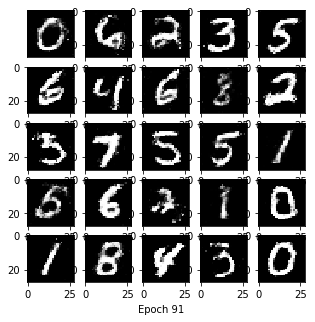

Iter : 90
D_loss : 1.2247517108917236
G_loss : 0.7950640916824341



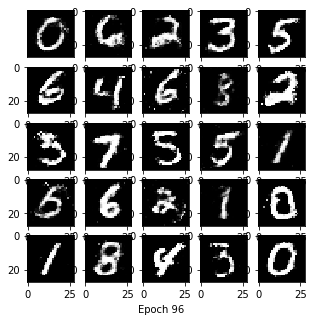

Iter : 95
D_loss : 1.214510202407837
G_loss : 0.7138529419898987



In [11]:
for it in range(100):
    for iter in range(mnist.train.num_examples // batch_size):
        x_ = train_set[iter*batch_size :(iter+1) * batch_size]
        y_ = train_labels[iter*batch_size : (iter+1) * batch_size]
        
        z_ = np.random.normal(0, 1, (batch_size, 100))
        
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict = {x: x_, y: y_, z: z_, isTrain : True})
        
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict = {y: y_, z: z_, isTrain :True})
        
    if it % 5 ==0:
        show_result((it+1))
        print("Iter : {}".format(it))
        print("D_loss : {}".format(D_loss_curr))
        print("G_loss : {}".format(G_loss_curr))
        print()